In [1]:
"""
Jupytext-style script for:
02_linear_baseline_single_station.ipynb
"""



'\nJupytext-style script for:\n02_linear_baseline_single_station.ipynb\n'

# Linear Ridge baseline for single-station salinity forecasting

This notebook builds a 1-step-ahead linear baseline model (Ridge regression) to predict salinity at a single station using the cleaned per-station datasets in `data/clean/`. The Ridge model uses recent history of salinity and hydrological drivers as inputs, and its performance is compared against a simple persistence baseline that assumes salinity at the next step equals the last observed value.



## Imports and configuration

This section imports the scientific Python stack, scikit-learn tools for scaling and evaluation, and the Ridge regression model. It also defines basic configuration such as the station name, lookback window, and fractions of data reserved for validation and testing. These parameters can be adjusted to explore different stations or horizons.



In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Base directories
BASE_DIR = Path(".").resolve()
CLEAN_DIR = BASE_DIR / "data" / "clean"

# Station and model configuration
STATION_NAME = "AnDinh"  # change to another station name as needed
LOOKBACK = 48            # number of time steps in each input sequence
VAL_FRACTION = 0.2       # fraction of samples for validation (by time)
TEST_FRACTION = 0.2      # fraction of samples for test (by time)

# Ridge configuration
ALPHA = 1.0              # L2 regularisation strength

# Sanity check for fractions
if VAL_FRACTION + TEST_FRACTION >= 1.0:
    raise ValueError("VAL_FRACTION + TEST_FRACTION must be < 1.0")

# For reproducibility of any stochastic steps
np.random.seed(42)



## Load station dataset and inspect

We load the cleaned per-station dataset from `data/clean/` and treat the `datetime` column as the index. A quick structural inspection confirms column types and coverage, and a simple plot of the salinity time series helps to understand the temporal behaviour at the chosen station.



Loaded station file: C:\Users\User\Desktop\Disertation\data\clean\station_AnDinh.csv

Head:
                     salinity  Q_MyThuan_Station Code  Q_MyThuan_Value  \
datetime                                                                 
1996-02-02 03:00:00       0.1                     NaN              NaN   
1996-02-02 05:00:00       0.1                     NaN              NaN   
1996-02-02 07:00:00       0.1                     NaN              NaN   
1996-02-04 17:00:00       0.1                     NaN              NaN   
1996-02-04 19:00:00       0.1                     NaN              NaN   

                     Q_CanTho_Station Code  Q_CanTho_Value  \
datetime                                                     
1996-02-02 03:00:00                    NaN             NaN   
1996-02-02 05:00:00                    NaN             NaN   
1996-02-02 07:00:00                    NaN             NaN   
1996-02-04 17:00:00                    NaN             NaN   
1996-02-04 19:00:

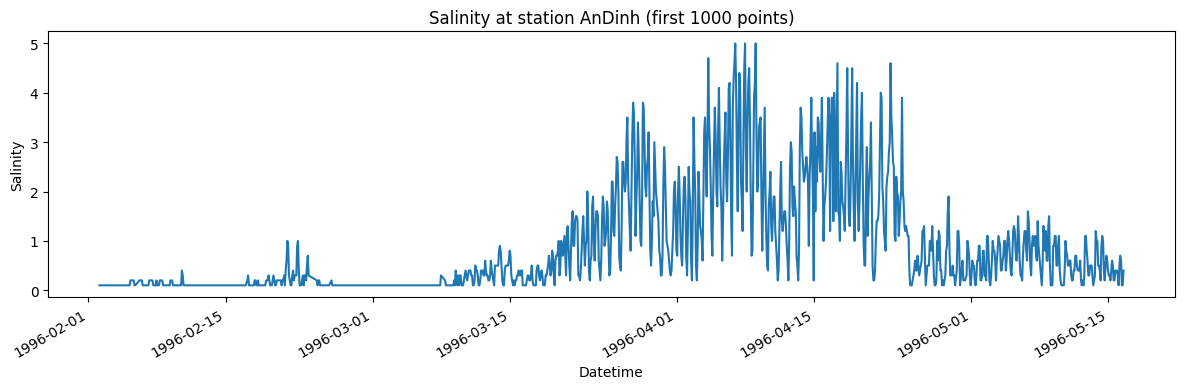

In [3]:
station_file = CLEAN_DIR / f"station_{STATION_NAME}.csv"
if not station_file.exists():
    raise FileNotFoundError(f"Could not find cleaned file for station {STATION_NAME!r}: {station_file}")

df = pd.read_csv(station_file, index_col="datetime", parse_dates=True)

print(f"Loaded station file: {station_file}")
print("\nHead:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nTime coverage and row count:")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")
print(f"Number of rows: {len(df)}")

# Plot salinity over time (full series or first 1000 points if very long)
if "salinity" not in df.columns:
    raise KeyError("Expected 'salinity' column in cleaned station dataset.")

plt.figure(figsize=(12, 4))
if len(df) > 1000:
    df["salinity"].iloc[:1000].plot()
    plt.title(f"Salinity at station {STATION_NAME} (first 1000 points)")
else:
    df["salinity"].plot()
    plt.title(f"Salinity at station {STATION_NAME}")
plt.ylabel("Salinity")
plt.xlabel("Datetime")
plt.tight_layout()
plt.show()



## Select features and drop non-numeric / station-code columns

Salinity is the prediction target; all remaining numeric columns are candidate input features. Non-numeric columns (for example station identifiers or text flags) are removed, and any column whose name contains `"Station Code"` is dropped explicitly. The final feature list is inspected, along with basic missingness statistics.



In [4]:
# Drop non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop any station code columns
station_code_cols = [c for c in df.columns if "Station Code" in c]

cols_to_drop = sorted(set(non_numeric_cols).union(station_code_cols))
if cols_to_drop:
    print("\nDropping non-numeric / station-code columns:")
    print(cols_to_drop)
    df = df.drop(columns=cols_to_drop)

# Confirm target presence
target_col = "salinity"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found after dropping non-numeric columns.")

# Define feature columns (excluding the explicit target)
feature_cols = [c for c in df.columns if c != target_col]

print(f"\nNumber of feature columns: {len(feature_cols)}")
print("Feature columns:")
print(feature_cols)

# Basic missingness stats (percentage of NaNs per column)
missing_pct = df[feature_cols + [target_col]].isna().mean() * 100
print("\nMissingness (% NaN) per column:")
print(missing_pct.sort_values(ascending=False).round(2))




Dropping non-numeric / station-code columns:
['H_CaiLay_Station Code', 'H_CanTho_Station Code', 'H_ChoLach_Station Code', 'H_ChoMoi_Station Code', 'H_DaiNgai_Station Code', 'H_MyTho_Station Code', 'H_MyThuan_Station Code', 'H_PhungHiep_Station Code', 'H_TanChau_Station Code', 'H_TanHiep_Station Code', 'H_VamKenh_Station Code', 'H_VamNao_Station Code', 'H_ViThanh_Station Code', 'Q_CanTho_Station Code', 'Q_MyThuan_Station Code', 'Q_VamNao_Station Code', 'rain_Batri_Station Code', 'rain_BenLuc_Station Code', 'rain_CaMau_Station Code', 'rain_CaiBe_Station Code', 'rain_CaiLay_Station Code', 'rain_CanTho_Station Code', 'rain_ChauDoc_Station Code', 'rain_ChoMoi_Station Code', 'rain_DaiNgai_Station Code', 'rain_MyTho_Station Code', 'rain_MyThuan_Station Code', 'rain_PhungHiep_Station Code', 'rain_TanChau_Station Code', 'rain_TanHiep_Station Code', 'rain_VamKenh_Station Code', 'rain_VamNao_Station Code', 'rain_ViThanh_Station Code']

Number of feature columns: 33
Feature columns:
['Q_MyThuan_V

## Handle missing data (drop sparse features, then bad rows)

We first ensure that the target salinity is present. Very sparse input features (more than 80% missing values) are dropped to avoid carrying mostly-empty drivers. For the remaining features, rows where more than 20% of inputs are missing are removed, and any remaining rows with missing values are dropped. The final cleaned dataset and number of rows dropped at each step are reported.



In [5]:
rows_before = len(df)

# 1) Drop rows where salinity is NaN
rows_before_target = len(df)
df = df.dropna(subset=[target_col])
rows_after_target = len(df)
dropped_target = rows_before_target - rows_after_target
print(f"\nRows dropped due to missing target: {dropped_target}")

# Keep a copy of the target-only series for a possible fallback
df_target_only = df[[target_col]].copy()

# Recompute feature columns after any column drops
feature_cols = [c for c in df.columns if c != target_col]

# 2) Drop very sparse features (>80% NaN)
feature_missing_frac = df[feature_cols].isna().mean()
sparse_features = feature_missing_frac[feature_missing_frac > 0.8].index.tolist()

if sparse_features:
    print("Dropping features with >80% missing values:")
    print(sparse_features)
    df = df.drop(columns=sparse_features)
    feature_cols = [c for c in feature_cols if c not in sparse_features]

if not feature_cols:
    raise ValueError(
        "All candidate input features were dropped due to missingness. "
        "Consider loosening the 80% threshold or adding more drivers."
    )

# 3) Drop rows where more than 20% of remaining features are missing
row_missing_frac = df[feature_cols].isna().mean(axis=1)
mask_keep = row_missing_frac <= 0.2
dropped_rows_high_missing = (~mask_keep).sum()
df = df[mask_keep]
print(f"Rows dropped due to >20% missing inputs: {dropped_rows_high_missing}")

# 4) Drop any remaining rows with NaNs in the remaining features
rows_before_clean_features = len(df)
df = df.dropna(subset=feature_cols)
dropped_rows_any_missing = rows_before_clean_features - len(df)
print(f"Rows dropped due to remaining NaNs in features: {dropped_rows_any_missing}")

print("\nFinal cleaned shape and coverage:")
print(f"Shape: {df.shape}")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")
print(f"Total rows dropped: {rows_before - len(df)}")

if len(df) == 0:
    print(
        "No rows remaining after dropping sparse features and rows with missing inputs.\n"
        "Falling back to salinity-only (autoregressive) input."
    )
    df = df_target_only
    feature_cols = []
    print("\nFallback salinity-only shape and coverage:")
    print(f"Shape: {df.shape}")
    print(f"Start: {df.index.min()}")
    print(f"End:   {df.index.max()}")
elif len(df) <= LOOKBACK + 10:
    raise ValueError(
        f"Not enough rows ({len(df)}) after cleaning for lookback={LOOKBACK}. "
        "Consider reducing LOOKBACK or relaxing missing-data thresholds."
    )




Rows dropped due to missing target: 0
Dropping features with >80% missing values:
['Q_MyThuan_Value', 'Q_CanTho_Value', 'Q_VamNao_Value', 'H_PhungHiep_Value']
Rows dropped due to >20% missing inputs: 15478
Rows dropped due to remaining NaNs in features: 2414

Final cleaned shape and coverage:
Shape: (0, 30)
Start: NaT
End:   NaT
Total rows dropped: 17892
No rows remaining after dropping sparse features and rows with missing inputs.
Falling back to salinity-only (autoregressive) input.

Fallback salinity-only shape and coverage:
Shape: (17892, 1)
Start: 1996-02-02 03:00:00
End:   2023-05-29 23:00:00


## Build supervised sliding-window sequences

We now construct supervised learning sequences where the model predicts salinity at time `t+1` from the preceding `LOOKBACK` time steps of all features, including the past salinity values. The sequence function iterates over time and builds one sample per available window, returning input tensors `X_all` and targets `y_all`.



In [6]:
# For sequence building, include salinity along with the other features
all_feature_cols = [target_col] + feature_cols  # ensure salinity is first
data_all = df[all_feature_cols].values.astype("float32")
target = df[target_col].values.astype("float32")


def create_sequences(data: np.ndarray, target: np.ndarray, lookback: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Create sliding-window sequences for 1-step-ahead prediction.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (T, F) containing features (including salinity).
    target : np.ndarray
        Array of shape (T,) containing the target salinity.
    lookback : int
        Number of time steps in each input window.

    Returns
    -------
    X : np.ndarray
        Array of shape (N_samples, lookback, F).
    y : np.ndarray
        Array of shape (N_samples,) with salinity(t+1).
    """
    X_list: list[np.ndarray] = []
    y_list: list[float] = []
    T = len(target)

    for t in range(lookback - 1, T - 1):
        X_list.append(data[t - lookback + 1 : t + 1])
        y_list.append(target[t + 1])

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y


X_all, y_all = create_sequences(data_all, target, lookback=LOOKBACK)
time_index_all = df.index[LOOKBACK:]  # aligns with y_all

print("\nSequence shapes:")
print(f"X_all shape: {X_all.shape}  (samples, lookback, n_features)")
print(f"y_all shape: {y_all.shape}")




Sequence shapes:
X_all shape: (17844, 48, 1)  (samples, lookback, n_features)
y_all shape: (17844,)


## Train / validation / test split (chronological)

To respect temporal order, the sequence data are split into training, validation, and test sets using contiguous blocks. The earliest portion of the data is used for training, followed by a validation block, and the most recent samples are held out for testing. No shuffling is performed.



In [7]:
N = X_all.shape[0]
n_test = int(N * TEST_FRACTION)
n_val = int(N * VAL_FRACTION)
n_train = N - n_val - n_test

if n_train <= 0 or n_val <= 0 or n_test <= 0:
    raise ValueError(
        f"Invalid split sizes with N={N}, VAL_FRACTION={VAL_FRACTION}, TEST_FRACTION={TEST_FRACTION}."
    )

train_end = n_train
val_end = n_train + n_val

X_train_raw = X_all[:train_end]
X_val_raw = X_all[train_end:val_end]
X_test_raw = X_all[val_end:]

y_train_raw = y_all[:train_end]
y_val_raw = y_all[train_end:val_end]
y_test_raw = y_all[val_end:]

time_train = time_index_all[:train_end]
time_val = time_index_all[train_end:val_end]
time_test = time_index_all[val_end:]

print("Split sizes (samples):")
print(f"Train: {X_train_raw.shape[0]}")
print(f"Val:   {X_val_raw.shape[0]}")
print(f"Test:  {X_test_raw.shape[0]}")
print(f"Total: {N}")



Split sizes (samples):
Train: 10708
Val:   3568
Test:  3568
Total: 17844


## Scale features and target

Ridge regression benefits from standardised inputs and target. We standardise all feature values across the training windows using `StandardScaler` and apply the same transformation to validation and test sets. The salinity target is also standardised, but evaluation metrics are reported back in original salinity units by inverting this transformation.



In [8]:
n_features = X_train_raw.shape[2]

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit feature scaler on flattened training windows
X_train_flat_for_fit = X_train_raw.reshape(-1, n_features)
feature_scaler.fit(X_train_flat_for_fit)


def scale_feature_windows(X: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    n, L, F = X.shape
    X_flat = X.reshape(-1, F)
    X_scaled_flat = scaler.transform(X_flat)
    return X_scaled_flat.reshape(n, L, F)


X_train_scaled = scale_feature_windows(X_train_raw, feature_scaler)
X_val_scaled = scale_feature_windows(X_val_raw, feature_scaler)
X_test_scaled = scale_feature_windows(X_test_raw, feature_scaler)

# Fit target scaler on training targets
y_train_scaled = target_scaler.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_val_scaled = target_scaler.transform(y_val_raw.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test_raw.reshape(-1, 1)).ravel()

print("\nScaled shapes:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled:   {X_val_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")
print(f"y_train_scaled: {y_train_scaled.shape}")




Scaled shapes:
X_train_scaled: (10708, 48, 1)
X_val_scaled:   (3568, 48, 1)
X_test_scaled:  (3568, 48, 1)
y_train_scaled: (10708,)


## Persistence baseline (in original units)

The persistence baseline assumes that salinity at the next time step equals the last salinity value in the input window:

\\[
\\hat{y}_{t+1}^{(\\text{persist})} = y_t
\\]

We implement this directly in the scaled feature space by reading the salinity feature at the last step of each test window, and then convert these predictions back to original salinity units. MAE, RMSE, and R² are computed on the test set for later comparison.



In [9]:
# Salinity feature index within all_feature_cols (salinity was added first)
sal_idx = all_feature_cols.index(target_col)

# Persistence prediction in scaled space: last salinity in the window
y_pred_persist_scaled = X_test_scaled[:, -1, sal_idx]

# Convert predictions and test targets back to original units
y_pred_persist = target_scaler.inverse_transform(y_pred_persist_scaled.reshape(-1, 1)).ravel()
y_test_orig = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


mae_persist = mean_absolute_error(y_test_orig, y_pred_persist)
rmse_persist = rmse(y_test_orig, y_pred_persist)
r2_persist = r2_score(y_test_orig, y_pred_persist)

print("Persistence baseline metrics (test set, original units):")
print(f"MAE:  {mae_persist:.4f}")
print(f"RMSE: {rmse_persist:.4f}")
print(f"R²:   {r2_persist:.4f}")



Persistence baseline metrics (test set, original units):
MAE:  0.2692
RMSE: 0.4224
R²:   0.9674


## Ridge regression baseline

We now train a Ridge regression model on the standardised sequences. Each input window is flattened into a single feature vector of length `LOOKBACK × n_features`, and the Ridge model is fitted to predict the scaled next-step salinity. Predictions on the test set are then transformed back into original units and evaluated using the same metrics as the persistence baseline.



In [10]:
# Flatten scaled feature windows for linear regression
n_train, L, F = X_train_scaled.shape
n_val = X_val_scaled.shape[0]
n_test = X_test_scaled.shape[0]

X_train_flat = X_train_scaled.reshape(n_train, L * F)
X_val_flat = X_val_scaled.reshape(n_val, L * F)
X_test_flat = X_test_scaled.reshape(n_test, L * F)

# Ridge regression model
ridge = Ridge(alpha=ALPHA)
ridge.fit(X_train_flat, y_train_scaled)

# Optional validation R² in scaled space
val_r2_scaled = ridge.score(X_val_flat, y_val_scaled)
print(f"\nRidge validation R² (scaled targets): {val_r2_scaled:.4f}")

# Predictions on test set (scaled)
y_pred_ridge_scaled = ridge.predict(X_test_flat)

# Convert predictions back to original salinity units
y_pred_ridge = target_scaler.inverse_transform(y_pred_ridge_scaled.reshape(-1, 1)).ravel()

# Ridge metrics in original units
mae_ridge = mean_absolute_error(y_test_orig, y_pred_ridge)
rmse_ridge = rmse(y_test_orig, y_pred_ridge)
r2_ridge = r2_score(y_test_orig, y_pred_ridge)

print("Ridge regression metrics (test set, original units):")
print(f"MAE:  {mae_ridge:.4f}")
print(f"RMSE: {rmse_ridge:.4f}")
print(f"R²:   {r2_ridge:.4f}")




Ridge validation R² (scaled targets): 0.9011
Ridge regression metrics (test set, original units):
MAE:  0.2136
RMSE: 0.3420
R²:   0.9786


## Comparison table and simple plots

We compare persistence and Ridge regression performance side-by-side and visualise how the Ridge predictions track the observed salinity over part of the test period. A scatter plot of observed versus predicted values offers a compact view of bias and spread.




Test-set metrics comparison (original salinity units):
                MAE    RMSE      R2
Persistence  0.2692  0.4224  0.9674
Ridge        0.2136  0.3420  0.9786


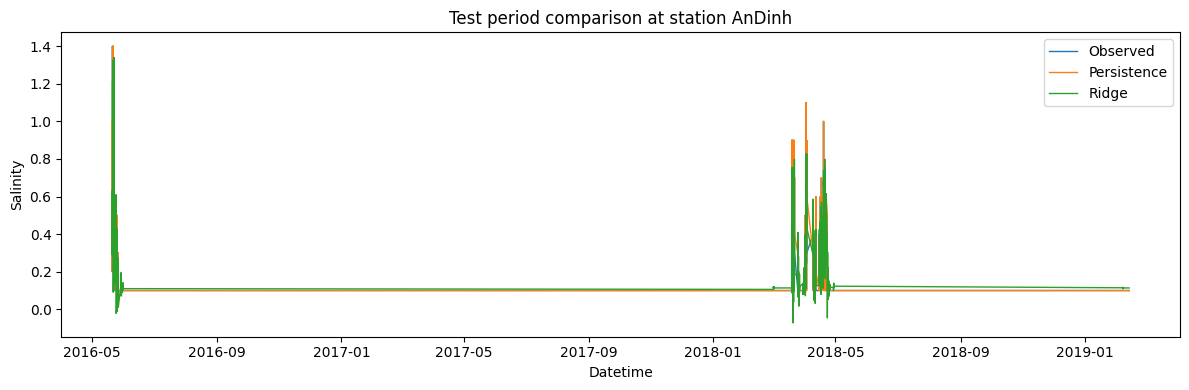

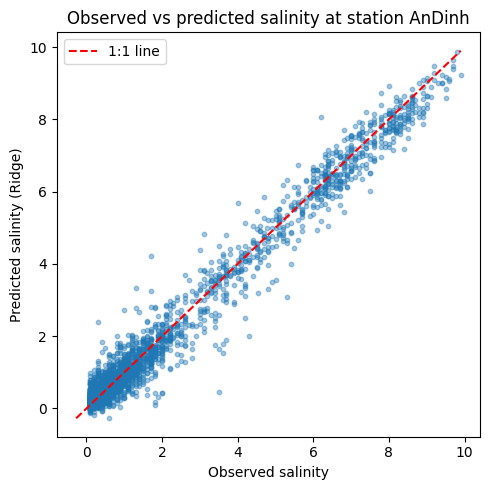

: 

In [ ]:
metrics_df = pd.DataFrame(
    {
        "MAE": [mae_persist, mae_ridge],
        "RMSE": [rmse_persist, rmse_ridge],
        "R2": [r2_persist, r2_ridge],
    },
    index=["Persistence", "Ridge"],
)

print("\nTest-set metrics comparison (original salinity units):")
print(metrics_df.round(4))

# Time-series snippet for the first 500 test samples (or fewer if smaller)
n_plot = min(500, len(y_test_orig))
idx_plot = slice(0, n_plot)

plt.figure(figsize=(12, 4))
plt.plot(time_test[idx_plot], y_test_orig[idx_plot], label="Observed", linewidth=1)
plt.plot(time_test[idx_plot], y_pred_persist[idx_plot], label="Persistence", linewidth=1)
plt.plot(time_test[idx_plot], y_pred_ridge[idx_plot], label="Ridge", linewidth=1)
plt.xlabel("Datetime")
plt.ylabel("Salinity")
plt.title(f"Test period comparison at station {STATION_NAME}")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot: observed vs Ridge predictions
plt.figure(figsize=(5, 5))
plt.scatter(y_test_orig, y_pred_ridge, alpha=0.4, s=10)
min_val = float(min(y_test_orig.min(), y_pred_ridge.min()))
max_val = float(max(y_test_orig.max(), y_pred_ridge.max()))
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="1:1 line")
plt.xlabel("Observed salinity")
plt.ylabel("Predicted salinity (Ridge)")
plt.title(f"Observed vs predicted salinity at station {STATION_NAME}")
plt.legend()
plt.tight_layout()
plt.show()



## Summary and notes

This notebook trained a 1-step-ahead Ridge regression baseline for station `STATION_NAME` using cleaned hourly data from `data/clean/`. After dropping sparse features and rows with excessive missingness, the remaining series were converted into sliding-window sequences with a lookback of 48 time steps and split into training, validation, and test sets in chronological order. All inputs and the salinity target were standardised for model fitting.

On the test set, both the persistence and Ridge models were evaluated using MAE, RMSE, and R² in original salinity units. Where the Ridge model clearly improves on persistence, it suggests that linear combinations of recent salinity and driver histories add predictive value beyond simple persistence. If performance is similar, the horizon may be strongly persistence-dominated, or additional features and model complexity may be required.

This Ridge baseline provides a useful linear reference against which to judge more flexible models such as LSTMs. Future work may include tuning the regularisation strength, exploring alternative lookback windows, and extending the input feature set with derived indices (for example tidal phase or seasonality markers).
